<a href="https://colab.research.google.com/github/mjbooo/Pr4AI/blob/main/04_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

## 1. Settings

### 1) Import required libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

### 2) Set hyperparameters

In [ ]:
batch_size = 256
learning_rate = 0.0002  # Ususally [0.0001, 0.001]
num_epochs = 10

## 2. Data

### 1) Download Data

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
from torchvision import transforms

# mnist_train  = MNIST('./', download=True, transform=transforms.Compose([transforms.ToTensor(),]), train=True)
mnist_train  = MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

# The previous code below from the class causes HTTP503 Error
'''
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
'''

--2021-05-14 08:07:32--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-05-14 08:07:32--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [        <=>         ]  33.20M  19.6MB/s    in 1.7s    

2021-05-14 08:07:34 (19.6 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

'\nmnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)\nmnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)\nmnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])\n'

torch.Size([1, 28, 28])
(1, 1, 3)
(3,)


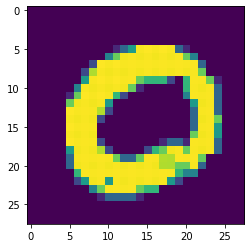

In [ ]:
print(mnist_train[0][0].size())   # (1, 28, 28)
plt.imshow(mnist_train[10][0].squeeze())
# plt.imshow: Display data as an image, i.e., on a 2D regular raster.
#The input may either be actual RGB(A) data, or 2D scalar data, which will be rendered as a pseudocolor image.

# squeeze: Remove axes of length one from a.
wt=np.array([[[1,2,3]]])
print(wt.shape)
print(wt.squeeze().shape)

In [ ]:
mnist_train[0][1]           # label

7

### 2) Set DataLoader

In [ ]:
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [ ]:
len(dataloaders["train"])

196

## 3. Model & Optimizer

### 1) Model

In [ ]:
# build your own autoencoder
# Autoencdoer SPEC: in my case, 784(28*28) -> 100 -> 30 -> 100 -> 784(28*28)

class Autoencoder(nn.Module):
    def __init__(self):
        # class definition - OOP in Python: member ftn needs 'self' notation
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),  # Linear layer
            nn.ReLU(),              # activation function
            nn.Linear(100,30),
            nn.ReLU()               # activation function 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(30,100),
            nn.ReLU(),                          # activation function
            nn.Linear(100,28*28),
            nn.Sigmoid()                     # activation function (Output should be in [0,1]. Then sigmoid would be useful to make model easy to train the data)
        )
                
    def forward(self, x):                # x: (batch_size, 1, 28, 28)
        batch_size = x.size(0)
        x = x.view(-1, 28*28)                        # reshape (view method) to 784(28*28)-dimensional vector
        # -1 can prevent error  

        encoded =    self.encoder(x)                 # hidden vector
        out = self.decoder(encoded).view(batch_size, 1, 28, 28)                   # final output. resize to input's size
        return out, encoded


### 2) Loss func & Optimizer

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = Autoencoder().to(device)
loss_func = nn.MSELoss()  # initialize the loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 4. Train 

In [ ]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=50):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time() # to measure time taken

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs): # use whole dataset = 1 epoch
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs=inputs.to(device)                                       # transfer inputs to GPU 
                # .to(device)' ensures you either work on cpu or gpu tho. If you don't have GPU, '.cuda()' would yield an error,

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):  # in  validation phase: Do NOT calc. the grad for the memory efficiency
                    outputs, encoded = model(inputs)
                    loss = criterion(outputs, inputs)                          # calculate a loss

                    # backward + optimize only if in training phase
                    # *important to memorize the canonical structure of this training phase
                    if phase == 'train':
                        loss.backward()                          # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            
            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

            # update the best performance model in validation phase
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [ ]:
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_func, optimizer, num_epochs=50)

# 10 epochs = validation loss continuously decreases: we should go further epoch! It doesn't cause overfitting yet. 
# We have to push the model til the model show the overfitting (when val error starts to increase) then do h.p tuning 


Epoch 0/49
----------
train Loss: 0.1204
val Loss: 0.0702

Epoch 1/49
----------
train Loss: 0.0658
val Loss: 0.0597

Epoch 2/49
----------
train Loss: 0.0525
val Loss: 0.0461

Epoch 3/49
----------
train Loss: 0.0425
val Loss: 0.0396

Epoch 4/49
----------
train Loss: 0.0376
val Loss: 0.0360

Epoch 5/49
----------
train Loss: 0.0345
val Loss: 0.0333

Epoch 6/49
----------
train Loss: 0.0317
val Loss: 0.0305

Epoch 7/49
----------
train Loss: 0.0291
val Loss: 0.0281

Epoch 8/49
----------
train Loss: 0.0271
val Loss: 0.0265

Epoch 9/49
----------
train Loss: 0.0256
val Loss: 0.0250

Epoch 10/49
----------
train Loss: 0.0241
val Loss: 0.0236

Epoch 11/49
----------
train Loss: 0.0229
val Loss: 0.0225

Epoch 12/49
----------
train Loss: 0.0219
val Loss: 0.0215

Epoch 13/49
----------
train Loss: 0.0210
val Loss: 0.0207

Epoch 14/49
----------
train Loss: 0.0202
val Loss: 0.0199

Epoch 15/49
----------
train Loss: 0.0195
val Loss: 0.0193

Epoch 16/49
----------
train Loss: 0.0189
val Loss

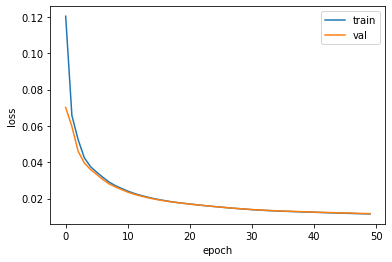

In [ ]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# val error continuously decreases even in 50 epochs! => should go further epoch

## 5. Check with Test Image

In [ ]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)

        outputs, encoded = best_model(inputs)
        test_loss = loss_func(outputs, inputs)
        
        running_loss += test_loss.item() * inputs.size(0)

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)        

0.011254627498984336


torch.Size([16, 28, 28])


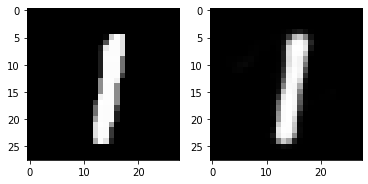

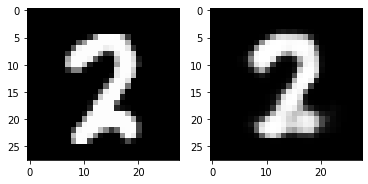

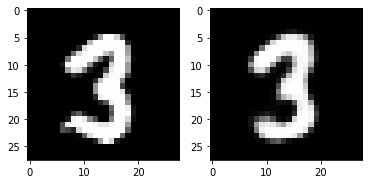

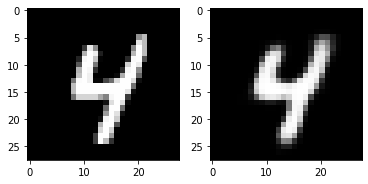

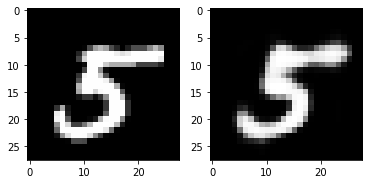

In [ ]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

# epoch increases (train the model sufficiently) = better reconstruction (less blurry)
for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2) 
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

## 6. Visualizing MNIST

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

In [ ]:
test_dataset_array = mnist_test.data.numpy() / 255
test_dataset_array = np.float32(test_dataset_array)
labels = mnist_test.targets.numpy()[:1000]

In [ ]:
test_dataset_array = torch.tensor(test_dataset_array[:1000])
inputs = test_dataset_array.to(device)
outputs, encoded = best_model(inputs) # encoded= latent vector, then visualize it by dimension reduction (2 dim)

In [ ]:
encoded = encoded.cpu().detach().numpy()
tsne = TSNE()   
X_test_2D = tsne.fit_transform(encoded)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

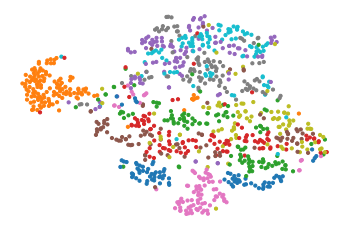

In [ ]:
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

# Orange: easily distinguished
# Visualizatin vs. Autoencoder (for reconstruction)

Let's make this diagram a bit prettier:

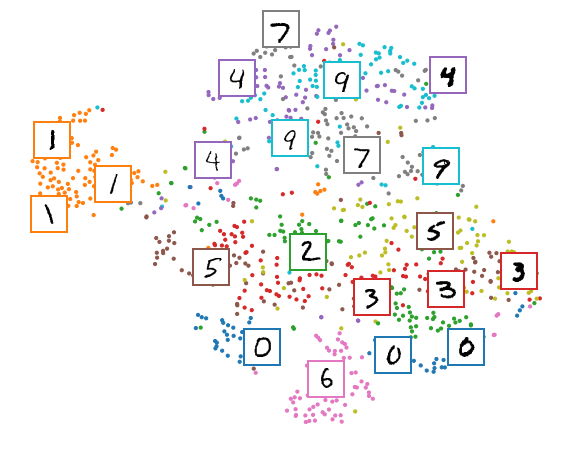

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(torch.squeeze(inputs).cpu().numpy()[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

# Denoising Autoencoder

In [ ]:
model_D = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_D.parameters(), lr=learning_rate)

In [ ]:
# It's all the same except for one: adding noise to inputs
# copy train_model() code and just add 'noise part'
# Hint: You can make noise like this.
# noise = torch.zeros(inputs.size(0), 1, 28, 28)
# nn.init.normal_(noise, 0, 0.1)

def train_model_D(model, dataloaders, criterion, optimizer, num_epochs=10):
    since = time.time() # to measure time taken

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs): # use whole dataset = 1 epoch
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                noise= torch.zeros(inputs.size(0), 1, 28, 28)
                nn.init.normal_(noise, 0, 0.1)  
                # prevent overfitting (because noise-added sample can be treated as a new sample)
                # However, adding random noise is not for anytime. It can changes the semantic of the image data 
                # MNIST is a quite simple dataset, so its semantic isn't affected that much
                
                noise=noise.to(device)
                inputs=inputs.to(device)                                       # transfer inputs to GPU 
                noise_inputs=noise+inputs
                # .to(device)' ensures you either work on cpu or gpu tho. If you don't have GPU, '.cuda()' would yield an error,

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):  # in  validation phase: Do NOT calc. the grad for the memory efficiency
                    outputs, encoded = model(noise_inputs)
                    loss = criterion(outputs, inputs)                          # calculate a loss

                    # backward + optimize only if in training phase
                    # *important to memorize the canonical structure of this training phase
                    if phase == 'train':
                        loss.backward()                          # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            
            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

            # update the best performance model in validation phase
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [ ]:
best_model_D, train_loss_history_D, val_loss_history_D = train_model_D(model_D, dataloaders, loss_func, optimizer, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.1163
val Loss: 0.0705

Epoch 1/19
----------
train Loss: 0.0670
val Loss: 0.0620

Epoch 2/19
----------
train Loss: 0.0565
val Loss: 0.0495

Epoch 3/19
----------
train Loss: 0.0441
val Loss: 0.0410

Epoch 4/19
----------
train Loss: 0.0393
val Loss: 0.0377

Epoch 5/19
----------
train Loss: 0.0360
val Loss: 0.0344

Epoch 6/19
----------
train Loss: 0.0326
val Loss: 0.0310

Epoch 7/19
----------
train Loss: 0.0296
val Loss: 0.0285

Epoch 8/19
----------
train Loss: 0.0276
val Loss: 0.0269

Epoch 9/19
----------
train Loss: 0.0261
val Loss: 0.0256

Epoch 10/19
----------
train Loss: 0.0249
val Loss: 0.0245

Epoch 11/19
----------
train Loss: 0.0238
val Loss: 0.0234

Epoch 12/19
----------
train Loss: 0.0228
val Loss: 0.0225

Epoch 13/19
----------
train Loss: 0.0220
val Loss: 0.0218

Epoch 14/19
----------
train Loss: 0.0213
val Loss: 0.0211

Epoch 15/19
----------
train Loss: 0.0206
val Loss: 0.0204

Epoch 16/19
----------
train Loss: 0.0200
val Loss

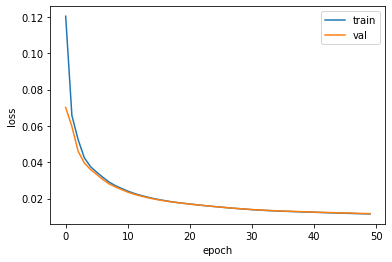

In [ ]:
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
  running_loss = 0.0
  for inputs, labels in dataloaders['test']:
      noise = nn.init.normal_(torch.FloatTensor(inputs.size(0), 1, 28, 28), 0, 0.1)
      noise = noise.to(device)
      inputs = inputs.to(device)
      noise_inputs = inputs + noise

      outputs, encoded = best_model_D(noise_inputs)
      test_loss = loss_func(outputs, inputs)
      
      running_loss += test_loss.item()* inputs.size(0)

  test_loss = running_loss / len(dataloaders['test'].dataset)
  print(test_loss) 

0.017638002248108388


torch.Size([16, 28, 28])


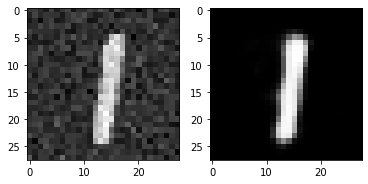

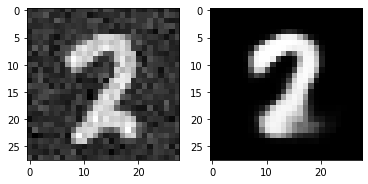

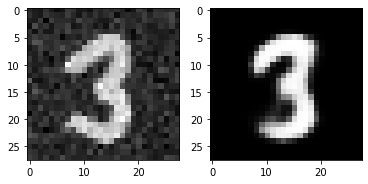

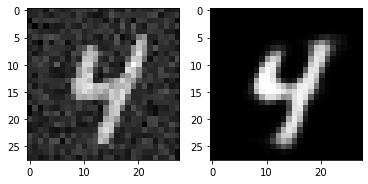

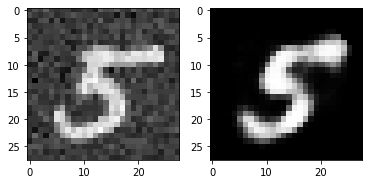

In [ ]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(noise_inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

# input images have some noises, but our autoencoder learns meaningful pattern and reconstructed it well.
